<a href="https://colab.research.google.com/github/Aayush360/Fast_AI/blob/master/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [63]:
#hide
from fastbook import *

In [64]:
path = untar_data(URLs.PASCAL_2007)

In [65]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.json')]

In [66]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [67]:
# using pandas for manipulating dataframe

df.iloc[:,1]

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object

In [68]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [69]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [70]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

## Constructing a DataBlock

In [71]:
# datablock created with no parameter

dblock = DataBlock()
dsets = dblock.datasets(df)

In [72]:
len(dsets.train)

4009

In [73]:
dsets.train[0]

(fname       007483.jpg
 labels          person
 is_valid         False
 Name: 3775, dtype: object, fname       007483.jpg
 labels          person
 is_valid         False
 Name: 3775, dtype: object)

In [74]:
# grab appropriate field from the dataframe

dblock = DataBlock(get_x =lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('002906.jpg', 'train')

In [75]:
# using labmda expression, shortcut for defining and then referring to a function
# great way for quickly iterating

In [76]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('009434.jpg', 'car person')

In [77]:
# need independent variable as complete path, so that we can open it as an image
# need dependent variable separated by a ' ' , space

In [78]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/001229.jpg'), ['bottle', 'person'])

In [79]:
# open image and do the conversion to tensors
# create a function get_x to get the training file
# create a function to extract the corresponding label and pass it to DataBlock


In [80]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x=get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=333x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [81]:
get_x

<function __main__.get_x>

In [82]:
idx = torch.where(dsets.train[0][1]==1.)[0]

In [83]:
dsets.train.vocab[idx]

(#1) ['dog']

In [84]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

In [85]:
dblock= DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter= splitter,
                  get_x = get_x,
                  get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [86]:
dsets.valid[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [87]:
# create dataloaders to ensure every item are of the same size

In [88]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)


In [89]:
#dls.show_batch(nrows=1,ncols=3);

## Create a Learner

In [90]:
# a learner object contains four main thing: a model,a dataloaders object, an optimizer and the loss function. 

In [ ]:
# you have to move the weights(model) to the gpu as well using model.cuda() 
learn = cnn_learner(dls, resnet18)
learn.model.cuda()

In [92]:
x,y = dls.train.one_batch()


In [93]:
activs = learn.model(x)


In [94]:
activs[0]

tensor([-2.0879, -1.5919, -1.4272, -4.5369,  2.7062,  0.4795, -0.4433,  1.9418,  0.6670,  1.4046, -1.5738,  0.0294, -1.0615, -0.6311,  0.0783, -0.3345, -1.0094,  2.4729, -2.5334, -2.2094],
       device='cuda:0', grad_fn=<SelectBackward>)

In [96]:
# defining a loss function

def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [97]:
# this is available in PyTorch

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs,y)
loss

tensor(1.0619, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

## Accuracy for multiple labels

In [98]:
# after applying the sigmoid to our activation function, we need to decide which ones are 0 and which are 1 by picking the threshold.
# each value above the threshold will be considered as 1 and rest will be 0

In [99]:
def accu_multi(inp, targ, thres=0.5, sigmoid=True):
  " compute accuracy when `input` and `target` are the same size"
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thres)==targ.bool()).float().mean()

In [100]:
# can modify the function using partial to replace the default argument

In [102]:
def say_hello(name, say_what='Hello'): return f"{say_what} {name}."

say_hello('aayush'), say_hello('Aayush','Ahoy!')


('Hello aayush.', 'Ahoy! Aayush.')

In [103]:
# switch to frech version using partial

f = partial(say_hello, say_what='bojour')
f('Aayush')

'bojour Aayush.'

## Train our Model

In [104]:
learn = cnn_learner(dls,resnet50, metrics=partial(accu_multi, thres=0.2))
learn.fine_tune(3, base_lr=3e-3,freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accu_multi,time
0,0.940375,0.702412,0.226235,00:29
1,0.819242,0.554809,0.291275,00:29
2,0.597309,0.206544,0.807530,00:28
3,0.357017,0.126045,0.941275,00:28


epoch,train_loss,valid_loss,accu_multi,time
0,0.131384,0.121592,0.934920,00:29
1,0.118849,0.110005,0.951255,00:28
2,0.098752,0.103116,0.949641,00:28


In [105]:
learn.metrics = partial(accu_multi, thres=0.1) # if threshold is too low, fail to select correcly labeled object
learn.validate()

(#2) [0.10311601310968399,0.9276294112205505]

In [106]:
# if you set threshold to be very high, we will see only those objects about which the model is very confident

learn.metrics = partial(accu_multi, thres=0.99) 
learn.validate()


(#2) [0.10311601310968399,0.9426095485687256]

In [107]:
preds, targs = learn.get_preds()

In [108]:
accuracy_multi(preds, targs, thresh = 0.9, sigmoid=False)

tensor(0.9562)

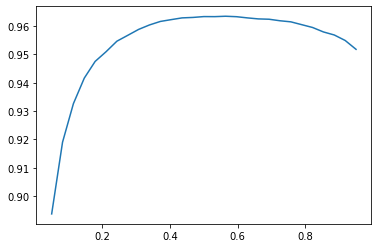

In [110]:
# use this approach to find best accuracy level

xs = torch.linspace(0.05,0.95,29)
accs = [accu_multi(preds, targs, i, False) for i in xs]
plt.plot(xs,accs);